In [17]:
#Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
#To ignore warnings
import warnings
warnings.filterwarnings("ignore")

#to see all columns
pd.set_option('display.max_columns', None)

print("Libraries imported successfully!")

Libraries imported successfully!


In [18]:
#Load the bitcoin dataset
df = pd.read_csv(r"C:\Users\Ritu Saxena\OneDrive\Desktop\Amdox\Cryptocurrency_Project_Amdox\btcusd_1-min_data.csv")

#Show first few rows
print("Shape of data:",df.shape)
df.head()

Shape of data: (1048575, 6)


,Timestamp,Open,High,Low,Close,Volume
0,1325412060,4.58,4.58,4.58,4.58,0.0
1,1325412120,4.58,4.58,4.58,4.58,0.0
2,1325412180,4.58,4.58,4.58,4.58,0.0
3,1325412240,4.58,4.58,4.58,4.58,0.0
4,1325412300,4.58,4.58,4.58,4.58,0.0


In [19]:
#Convert timestamp to datetime and set as index

#Convert to datetime  (timestamp is in seconds)
df['Timestamp'] = pd.to_datetime(df['Timestamp'],unit='s')

#Sort by time
df = df.sort_values('Timestamp')

#Set timestamp as index
df = df.set_index('Timestamp')

#Display info
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1048575 entries, 2012-01-01 10:01:00 to 2013-12-29 14:15:00
Data columns (total 5 columns):
 #   Column  Non-Null Count    Dtype  
---  ------  --------------    -----  
 0   Open    1048575 non-null  float64
 1   High    1048575 non-null  float64
 2   Low     1048575 non-null  float64
 3   Close   1048575 non-null  float64
 4   Volume  1048575 non-null  float64
dtypes: float64(5)
memory usage: 48.0 MB
None


,Open,High,Low,Close,Volume
Timestamp,,,,,
2012-01-01 10:01:00,4.58,4.58,4.58,4.58,0.0
2012-01-01 10:02:00,4.58,4.58,4.58,4.58,0.0
2012-01-01 10:03:00,4.58,4.58,4.58,4.58,0.0
2012-01-01 10:04:00,4.58,4.58,4.58,4.58,0.0
2012-01-01 10:05:00,4.58,4.58,4.58,4.58,0.0


In [20]:
#Check for missing or zero values
print("Missing values:\n", df.isnull().sum())
print("\nNumber of zero values:\n", (df == 0).sum())

Missing values:
 Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64

Number of zero values:
 Open           0
High           0
Low            0
Close          0
Volume    705352
dtype: int64


In [21]:
#Clean data and resample to daily prices

#Check again which columns we have
print("Columns:",df.columns.tolist())

#Make sure required columns exist
required_cols = ['Open', 'High', 'Low', 'Close', 'Volume']
for col in required_cols:
    if col not in df.columns:
        raise ValueError(f"Missing column: {col}")

#Handle missing or invalid data
#Fill missing price values with forward fill, and replace negative or zero volume with 0
df[['Open','High','Low','Close']] = df[['Open','High','Low','Close']].ffill().bfill()
df['Volume'] = df['Volume'].fillna(0).clip(lower=0)

#Resample to daily level (D = 1 day)
daily = df.resample('D').agg({
    'Open': 'first',
    'High': 'max',
    'Low': 'min',
    'Close': 'last',
    'Volume': 'sum'
})

#Drop days with no trading data (open = NaN)
daily = daily.dropna(subset=['Open'])

print("Resampling done successfully!")
print("New shape:", daily.shape)
print("\nPreview of daily data:")
display(daily.head())

Columns: ['Open', 'High', 'Low', 'Close', 'Volume']
Resampling done successfully!
New shape: (729, 5)

Preview of daily data:


,Open,High,Low,Close,Volume
Timestamp,,,,,
2012-01-01,4.58,4.84,4.58,4.84,10.000000
2012-01-02,4.84,5.00,4.84,5.00,10.100000
2012-01-03,5.00,5.32,5.00,5.29,107.085281
2012-01-04,5.29,5.57,4.93,5.57,107.233260
2012-01-05,5.57,6.46,5.57,6.42,70.328742


Feature Engineering and Exploratory Data Analysis (EDA)

In [22]:
plt.style.use("seaborn-v0_8")

# ---- FEATURE ENGINEERING ----

#Calculate Daily Return (percentage change)
daily['daily_return'] = daily['Close'].pct_change() * 100  #in %

#Calculate Daily Price Change
daily['price_change'] = daily['Close'] - daily['Open']

#Calculate Volatility (how much price fluctuates in a day)
daily['volatility'] = ((daily['High'] - daily['Low']) / daily['Open']) * 100

#Calculate Moving Averages (to smooth trends)
daily['MA7'] = daily['Close'].rolling(window=7).mean()    #7-day moving average
daily['MA30'] = daily['Close'].rolling(window=30).mean()  #30-day moving average

#Rmove rows with NaN due to rolling
daily = daily.dropna()

print("Feature engineering done successfully!")
print("\Preview:")
display(daily.head())

Feature engineering done successfully!
\Preview:


,Open,High,Low,Close,Volume,daily_return,price_change,volatility,MA7,MA30
Timestamp,,,,,,,,,,
2012-01-30,5.90,5.90,5.30,5.58,22.380000,-5.423729,-0.32,10.169492,5.870000,6.340333
2012-01-31,5.58,6.22,5.55,5.55,104.718333,-0.537634,-0.03,12.007168,5.727143,6.364000
2012-02-01,5.55,6.00,3.80,5.99,13.552446,7.927928,0.44,39.639640,5.725714,6.397000
2012-02-02,5.99,6.26,5.54,6.26,123.582638,4.507513,0.27,12.020033,5.724286,6.429333
2012-02-03,6.26,6.35,5.93,6.29,283.382106,0.479233,0.03,6.709265,5.782857,6.453333


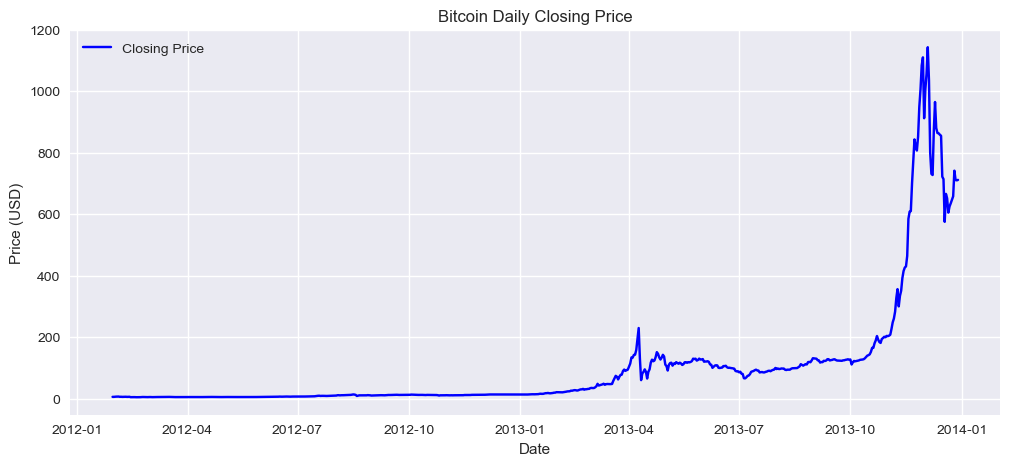

In [23]:
#Visualization - Bitcoin closing price trend

plt.figure(figsize=(12,5))
plt.plot(daily.index, daily['Close'], label='Closing Price', color='blue')
plt.title('Bitcoin Daily Closing Price')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True)
plt.show()

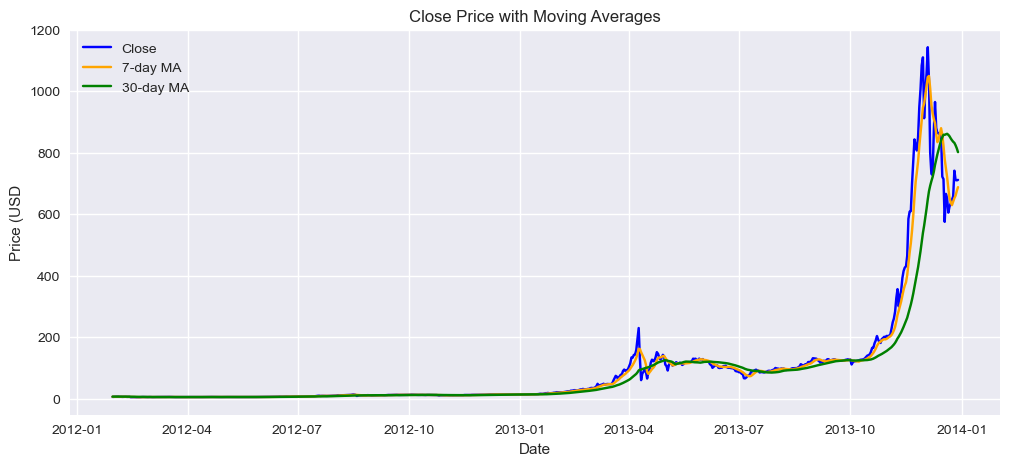

In [24]:
#Close price with 7-day and 30-day moving averages

plt.figure(figsize=(12,5))
plt.plot(daily.index, daily['Close'], label='Close', color='blue')
plt.plot(daily.index, daily['MA7'], label='7-day MA', color='orange')
plt.plot(daily.index, daily['MA30'], label='30-day MA', color='green')
plt.title('Close Price with Moving Averages')
plt.xlabel('Date')
plt.ylabel('Price (USD')
plt.legend()
plt.show()

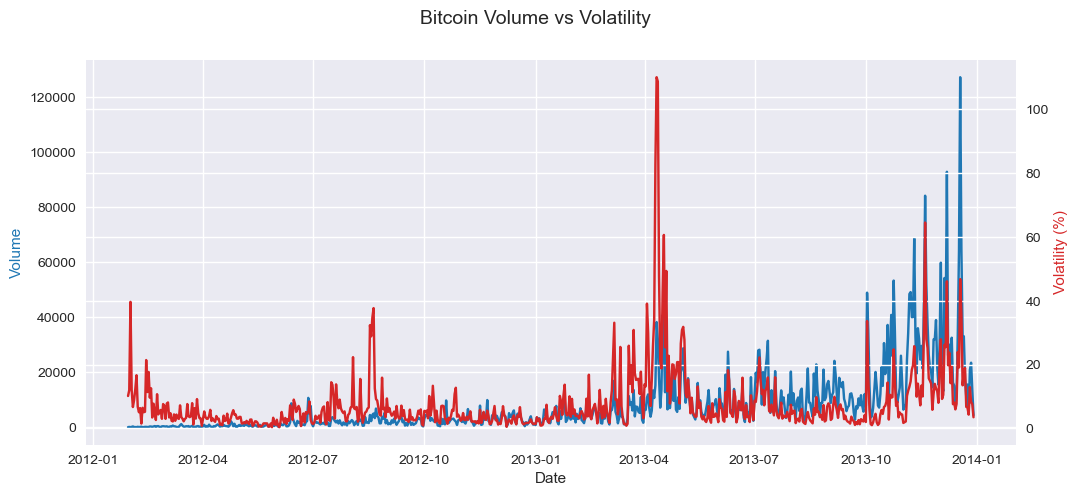

In [25]:
#Volume and Volatility Trends

fig, ax1 = plt.subplots(figsize=(12,5))

ax1.set_xlabel('Date')
ax1.set_ylabel('Volume', color='tab:blue')
ax1.plot(daily.index, daily['Volume'], color='tab:blue', label='Volume')

ax2 = ax1.twinx()
ax2.set_ylabel('Volatility (%)', color='tab:red')
ax2.plot(daily.index, daily['volatility'], color='tab:red', label='Volatility')

fig.suptitle('Bitcoin Volume vs Volatility', fontsize=14)
plt.show()

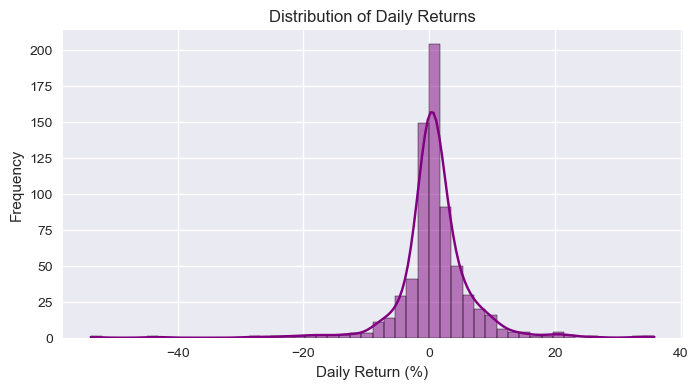

In [26]:
#Distribution of daily returns

plt.figure(figsize=(8,4))
sns.histplot(daily['daily_return'], bins=50, kde=True, color='purple')
plt.title('Distribution of Daily Returns')
plt.xlabel('Daily Return (%)')
plt.ylabel('Frequency')
plt.show()

Train data size: 670
Test data size: 30

ADF Statistic: 2.407192811468035
p-value: 0.9990136544900088
Data is not stationary. Differencing will be applied.

Model Summary:
                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  670
Model:                 ARIMA(5, 1, 2)   Log Likelihood               -2455.464
Date:                Sat, 08 Nov 2025   AIC                           4926.928
Time:                        16:17:58   BIC                           4962.974
Sample:                    01-30-2012   HQIC                          4940.891
                         - 11-29-2013                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6032      0.123      

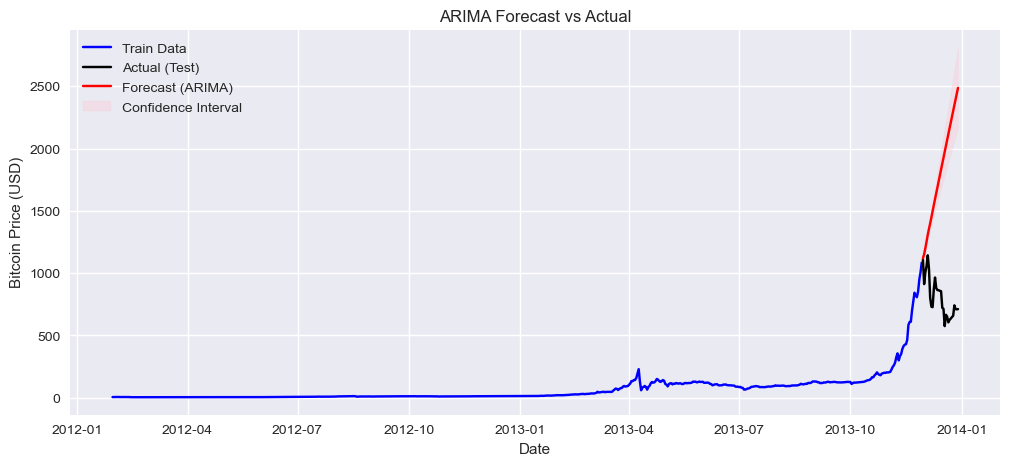

In [27]:
#Time Series Forecasting - ARIMA Model

import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error, mean_absolute_error

#Select target column for forecasting
target = daily['Close']

#Train-test split (last 30 days for testing)
train = target[:-30]
test = target[-30:]

print("Train data size:", len(train))
print("Test data size:", len(test))

#Check if the data is stationary using Augmented Dickey-Fuller (ADF) test
adf_result = adfuller(train)
print("\nADF Statistic:", adf_result[0])
print("p-value:", adf_result[1])

if adf_result[1] > 0.05:
    print("Data is not stationary. Differencing will be applied.")
    d=1
else:
    print("Data is stationary. No differencing needed.")
    d=0

#Build ARIMA model
p, q = 5, 2    #you can experiment with these values later
model = sm.tsa.ARIMA(train, order=(p, d, q))
model_fit = model.fit()

print("\nModel Summary:")
print(model_fit.summary())

#Forecast for next 30 days
forecast_result = model_fit.get_forecast(steps=30)
forecast_mean = forecast_result.predicted_mean
forecast_ci = forecast_result.conf_int()

##Align forecast with test dates
forecast_mean.index = test.index

#Evaluate model performance
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

print("\nModel Evaluation Metrics:")
print(f"RMSE: { rmse(test, forecast_mean):.2f}")
print(f"MAE: {mean_absolute_error(test, forecast_mean):.2f}")
print(f"MAPE: {mape(test, forecast_mean):.2f}%")

#Plot actual vs predicted
plt.figure(figsize=(12,5))
plt.plot(train.index, train, label='Train Data', color='blue')
plt.plot(test.index, test, label='Actual (Test)', color='black')
plt.plot(forecast_mean.index, forecast_mean, label='Forecast (ARIMA)', color='red')

ci_cols = forecast_ci.columns
lower_col = [c for c in ci_cols if 'lower' in c.lower()][0]
upper_col = [c for c in ci_cols if 'upper' in c.lower()][0]

plt.fill_between(forecast_ci.index,
                 forecast_ci[lower_col],
                 forecast_ci[upper_col], 
                 color='pink', alpha=0.3, label='Confidence Interval')

plt.title('ARIMA Forecast vs Actual')
plt.xlabel('Date')
plt.ylabel('Bitcoin Price (USD)')
plt.legend()
plt.grid(True)
plt.show()

In [36]:
#Prepare Prophet dataframe properly

from prophet import Prophet

# Ensure 'daily' exists and columns are lowercase
daily.columns = [c.strip().lower() for c in daily.columns]

#Create Prophet-ready dataframe (columns 'ds' and 'y')
prophet_df = daily.reset_index()[['Timestamp', 'close']].rename(
    columns={'Timestamp': 'ds', 'close': 'y'}
)

# Drop missing values
prophet_df = prophet_df.dropna(subset=['y'])

# Display a few rows
print("Prophet DataFrame ready:")
print(prophet_df.head())


Prophet DataFrame ready:
          ds     y
0 2012-01-30  5.58
1 2012-01-31  5.55
2 2012-02-01  5.99
3 2012-02-02  6.26
4 2012-02-03  6.29


Prophet DataFrame Ready:
          ds     y
0 2012-01-30  5.58
1 2012-01-31  5.55
2 2012-02-01  5.99
3 2012-02-02  6.26
4 2012-02-03  6.29


16:31:52 - cmdstanpy - INFO - Chain [1] start processing
16:31:52 - cmdstanpy - INFO - Chain [1] done processing


            ds        yhat  yhat_lower  yhat_upper
725 2014-01-24  848.583994  739.901710  960.942537
726 2014-01-25  852.814758  740.172507  958.903049
727 2014-01-26  854.882261  740.770412  972.255533
728 2014-01-27  862.690583  744.990364  972.186407
729 2014-01-28  869.900925  759.260570  990.415029


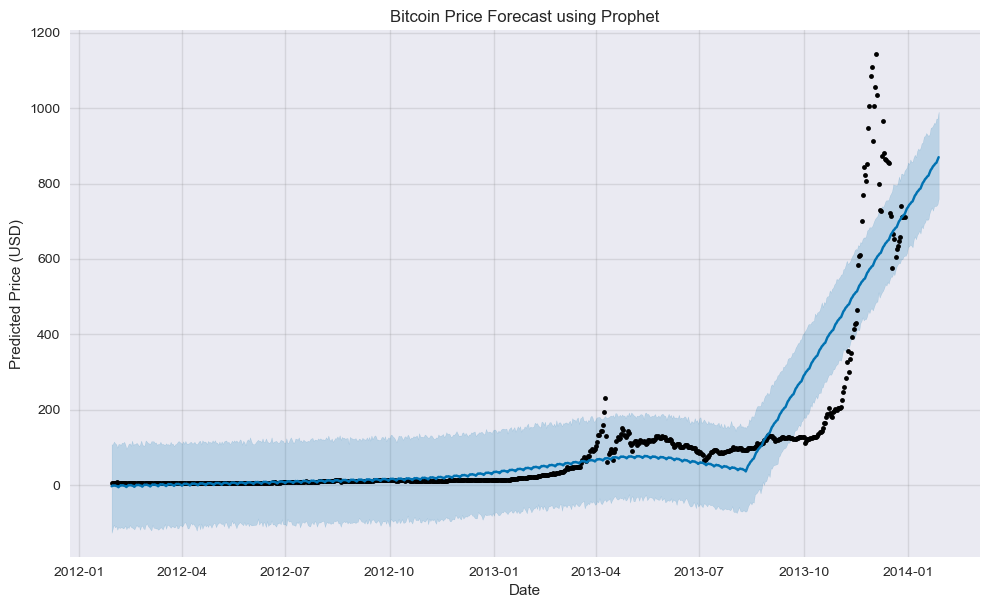

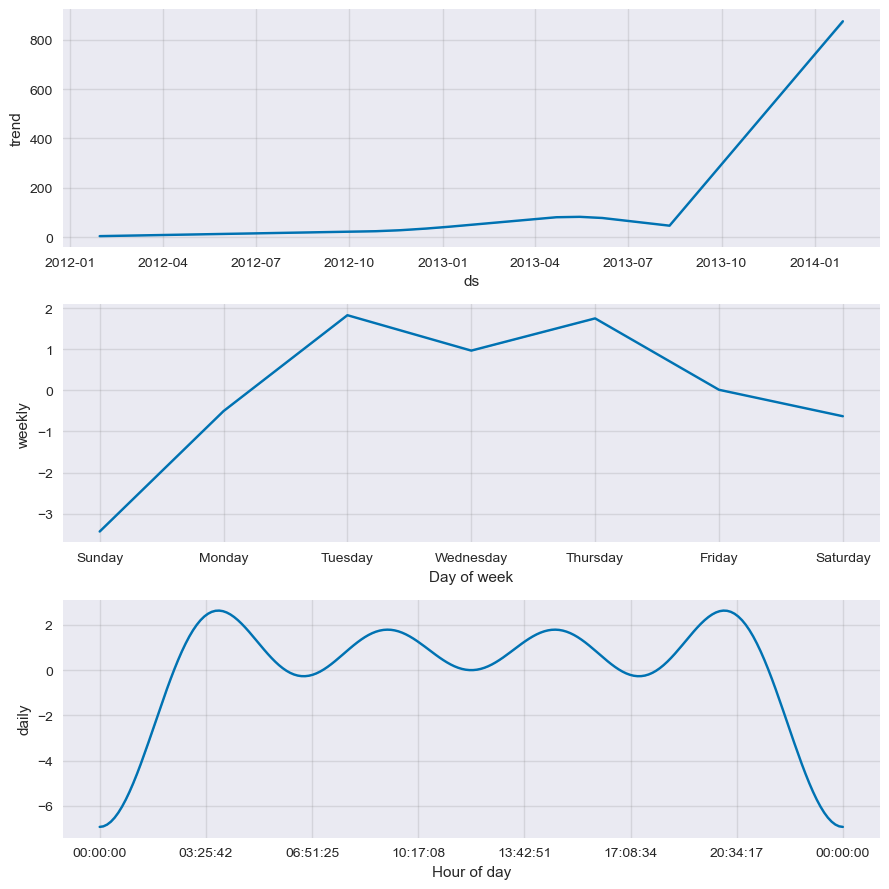

In [40]:
#Forecasting Bitcoin Prices with Prophet 

from prophet import Prophet

# Ensure column names are lowercase
daily.columns = [c.strip().lower() for c in daily.columns]

daily_reset = daily.reset_index()

date_col = None
for c in daily_reset.columns:
    if 'time' in c.lower() or 'date' in c.lower():
        date_col = c
        break

if date_col is None:
    raise KeyError("No timestamp or date column found even after reset_index(). Please check your DataFrame.")

#Prepare dataframe for Prophet
prophet_df = daily_reset.rename(columns={date_col: 'ds', 'close': 'y'})[['ds', 'y']]

#Drop missing rows
prophet_df = prophet_df.dropna(subset=['y'])

print("Prophet DataFrame Ready:")
print(prophet_df.head())

#Build and fit the model
m = Prophet(daily_seasonality=True)
m.fit(prophet_df)

#Make predictions for next 30 days
future = m.make_future_dataframe(periods=30)
forecast = m.predict(future)

print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail())

#Plot forecast
fig1 = m.plot(forecast)
plt.title("Bitcoin Price Forecast using Prophet")
plt.xlabel("Date")
plt.ylabel("Predicted Price (USD)")
plt.show()

#Plot trend and seasonality
fig2 = m.plot_components(forecast)
plt.show()


In [45]:
#Evaluate Prophet Forecast Accuracy

from sklearn.metrics import mean_squared_error, mean_absolute_error

# Get actual and predicted values for the overlapping period
actual = prophet_df['y'].values[-30:]   # last 30 actual days
predicted = forecast['yhat'].values[-30:]  # last 30 forecasted days

#Calculate metrics
rmse = np.sqrt(mean_squared_error(actual, predicted))
mae = mean_absolute_error(actual, predicted)
mape = np.mean(np.abs((actual - predicted) / actual)) * 100

print("Prophet Forecast Performance:")
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"MAPE: {mape:.2f}%")


Prophet Forecast Performance:
RMSE: 190.31
MAE: 164.69
MAPE: 20.65%


Shapes:
X_train: (610, 60, 1) y_train: (610,)
X_test: (30, 60, 1) y_test: (30,)
Epoch 1/25
39/39 ━━━━━━━━━━━━━━━━━━━━ 9s 47ms/step - loss: 0.0038
Epoch 2/25
39/39 ━━━━━━━━━━━━━━━━━━━━ 3s 69ms/step - loss: 6.9389e-04
Epoch 3/25
39/39 ━━━━━━━━━━━━━━━━━━━━ 3s 67ms/step - loss: 5.9860e-04
Epoch 4/25
39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 61ms/step - loss: 0.0013    
Epoch 5/25
39/39 ━━━━━━━━━━━━━━━━━━━━ 3s 63ms/step - loss: 5.8499e-04
Epoch 6/25
39/39 ━━━━━━━━━━━━━━━━━━━━ 3s 62ms/step - loss: 8.0663e-04
Epoch 7/25
39/39 ━━━━━━━━━━━━━━━━━━━━ 3s 63ms/step - loss: 4.0842e-04
Epoch 8/25
39/39 ━━━━━━━━━━━━━━━━━━━━ 3s 63ms/step - loss: 4.0760e-04
Epoch 9/25
39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - loss: 4.9908e-04
Epoch 10/25
39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - loss: 4.2754e-04
Epoch 11/25
39/39 ━━━━━━━━━━━━━━━━━━━━ 3s 62ms/step - loss: 4.3353e-04
Epoch 12/25
39/39 ━━━━━━━━━━━━━━━━━━━━ 3s 64ms/step - loss: 4.4878e-04
Epoch 13/25
39/39 ━━━━━━━━━━━━━━━━━━━━ 3s 65ms/step - loss: 6.0194e-04
Epoch 14/2

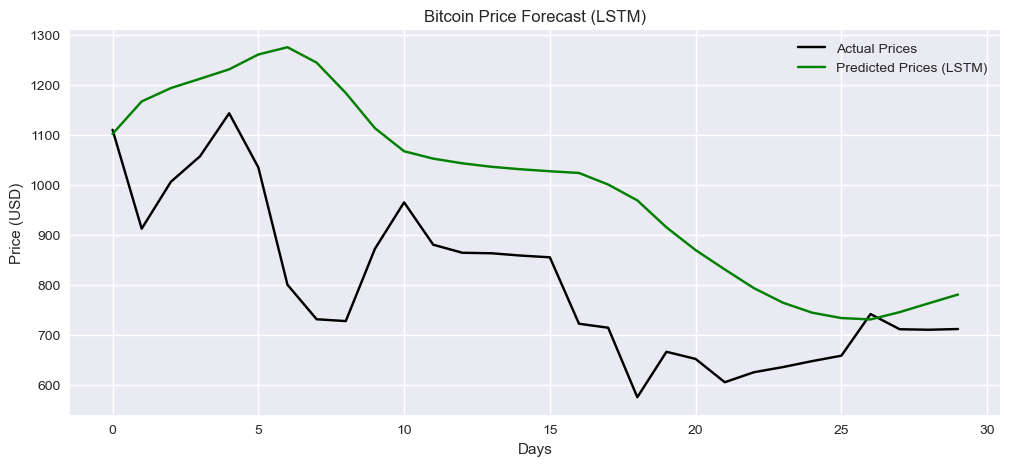

In [41]:
#Forecasting Bitcoin Prices using LSTM

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

daily.columns = [c.strip().lower() for c in daily.columns]


data = daily[['close']].values

#Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

#Create training sequences (past 60 days → next day)
sequence_length = 60

X = []  # initialize lists fresh each time
y = []

for i in range(sequence_length, len(scaled_data)):
    X.append(scaled_data[i-sequence_length:i, 0])
    y.append(scaled_data[i, 0])

X = np.array(X)
y = np.array(y)

#Reshape X for LSTM input [samples, timesteps, features]
X = np.reshape(X, (X.shape[0], X.shape[1], 1))

#Split into training and testing sets (last 30 days = test)
split = -30
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

print("Shapes:")
print("X_train:", X_train.shape, "y_train:", y_train.shape)
print("X_test:", X_test.shape, "y_test:", y_test.shape)

#Build LSTM model
model = Sequential()
model.add(LSTM(64, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(64, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mse')

#Train the model
history = model.fit(X_train, y_train, epochs=25, batch_size=16, verbose=1)

#Make predictions
pred_scaled = model.predict(X_test)
pred = scaler.inverse_transform(pred_scaled)
y_true = scaler.inverse_transform(y_test.reshape(-1, 1))

#Evaluate performance
rmse = np.sqrt(mean_squared_error(y_true, pred))
mae = mean_absolute_error(y_true, pred)
mape = np.mean(np.abs((y_true - pred) / y_true)) * 100

print("\nLSTM Model Performance:")
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"MAPE: {mape:.2f}%")

#Plot predictions vs actual values
plt.figure(figsize=(12, 5))
plt.plot(y_true, label='Actual Prices', color='black')
plt.plot(pred, label='Predicted Prices (LSTM)', color='green')
plt.title('Bitcoin Price Forecast (LSTM)')
plt.xlabel('Days')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True)
plt.show()


In [44]:
#Model Comparison and Summary 

# ENTER the evaluation metrics you obtained
results_data = {
    'Model':   ['ARIMA', 'Prophet', 'LSTM'],
    'RMSE':    [1139.89,190.31,235.06],
    'MAE':     [1002.80,164.69,196.24],
    'MAPE':    [140.64,20.65,25.94]190.31
MAE: 164.69
MAPE: 20.65%
}

#Create DataFrame
comparison_df = pd.DataFrame(results_data).set_index('Model')

# Show table
print("Model Performance Comparison:")
display(
    comparison_df.style.format(precision=2)
    .highlight_min(color='lightgreen', axis=0)
)

#Plot comparison only if numeric data is available
numeric_df = comparison_df.select_dtypes(include=['float', 'int'])

if numeric_df.empty or comparison_df.isnull().values.any():
    print("Some metrics are missing or non-numeric. Fill them to see the chart.")
else:
    numeric_df.plot(kind='bar', figsize=(8,5))
    plt.title("Model Performance Comparison (Lower = Better)")
    plt.ylabel("Error Metrics")
    plt.grid(True)
    plt.xticks(rotation=0)
    plt.show()

#Insight summary (printed automatically)
best_model = comparison_df['RMSE'].idxmin()
print(f"\nBest Performing Model Based on RMSE: {best_model}")
print("Lower RMSE, MAE, and MAPE indicate better forecast accuracy.")


ValueError: All arrays must be of the same length